In [1]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get the current scan frame from the STM, get atom positions using Gaussian fits, and program lateral manipulation moves (in order of their labeling in the figure) using GUI. 
This may require fine-tuning the parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only the surface features you want to see are registered in the image frame when you run the cell.

succeed to connect
	23 centroids


<IPython.core.display.Javascript object>


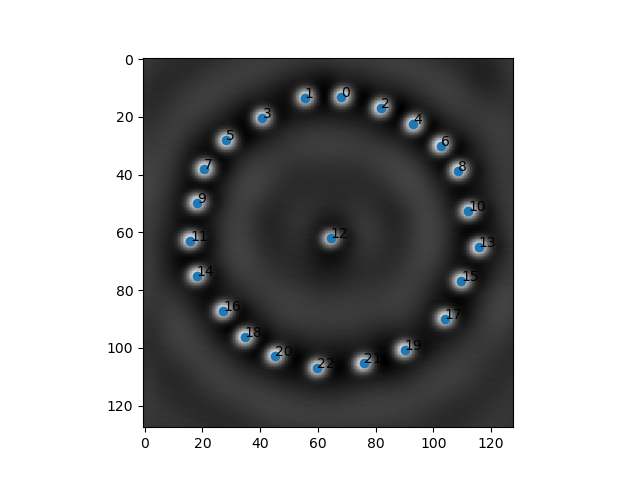

Textarea(value='[]', description='points:')

In [2]:
%matplotlib notebook

CC = Createc_Controller()

# f = r"Y:\labdata\Createc\STMDATA\Ag(111)\2022-03 Co Kondo corrals\04-04\A220405.101017.dat"
# C = CircCorralData(f, "label")
# C.occupied = True
# C.corral = True
# C.get_region_centroids()
# 

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=99, edge_cutoff=0.1, show=False)

# scale numbers between 0 and 1
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)

# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
plt.scatter(*np.array(C.centroids).T)

# give numbers to the atom positions
for n, c in enumerate(C.centroids):
    plt.text(*c,'%d' %(n))

# List for selected pixels
selected = []

# Create a text area for displaying the selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

# Function to run when a pixel is clicked
def onclick(event):
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    if (y, x) in selected:
        im[y,x] = C.im[y,x]
        dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
        selected.remove((y, x))
    else:
        dispmat[y,x,:] = [1,0,0]
        selected += [(y, x)]
    text_area.value = str(selected)  # str(dir(event))
    print(selected)
    plt.imshow(dispmat)
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Show the atom positions from the scan frame and the programmed lateral manipulations. If they are wrong, run the previous Jupyter notebook cell again and program the lateral manipulations again using the GUI.

In [13]:
nmx

15.98876953125

	Max height guess different from Gaussian fit on average by: 0.94 Å
	 2022-04-07 16:28:52.742428
	Central atom from Naive fit:  5.979150018300402 [65.04076597 60.08774157]
	Central atom from Gauss fit:  5.986183091805668 [65.60404405 60.54266201]


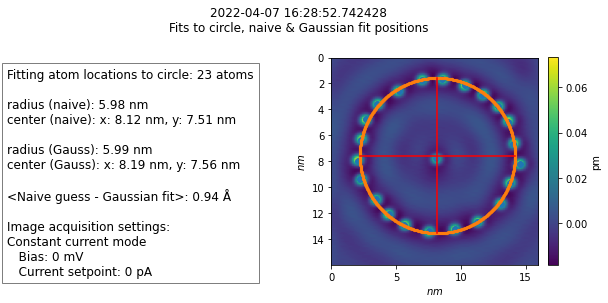

5.986183091805668

In [4]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1, savefig=False)

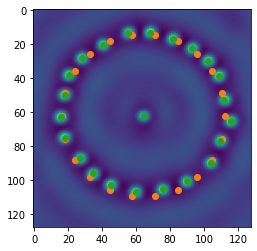

In [30]:
%matplotlib inline

n_wall_atoms = len(C.centroids) - 1
center = C.get_central_atom(C.centroids)

radius = 6
perfect_circle = np.array([[radius*np.cos(t), radius*np.sin(t)] for t in np.arange(0, 2*np.pi, 2*np.pi/n_wall_atoms)])
perfect_circle = list(map(C.nm_to_pix, perfect_circle))
perfect_circle += np.array(center)

plt.imshow(C.im);
plt.scatter(*center)
plt.scatter(*(np.array(perfect_circle).T))
plt.scatter(*np.array(C.centroids).T)
plt.show()

In [5]:
%matplotlib inline
assert(len(selected)==len(C.centroids))
for n, c in enumerate(C.centroids):
    plt.arrow(*c, *(np.array(list(reversed(selected[n])))-np.array(c)), c="o")
plt.imshow(dispmat);
plt.show()
#
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
centroids = C.centroids

AssertionError: 

## Program the lateral manipulation parameters and carry out the lateral manipulations in order 

In [6]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000

# for each "atom" in the image
for n in range(len(centroids)):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])))
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

NameError: name 'centroids' is not defined

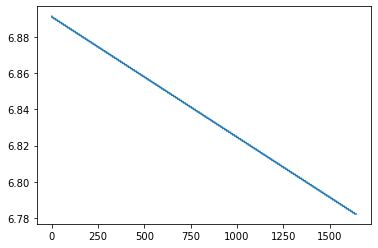

In [53]:
# the units of this is unknown ? 
plt.plot(latmandata.y)

##
fix so it works when the scan is not finished yet 

make the labels white rather than black, larger

add numbers to points when they're selected

set parameters back to scanning parameters after manipulation